In [1]:
!pip install pandas
!pip install statsmodels
!pip install matplotlib
!pip install seaborn
!pip install numpy

     |████████████████████████████████| 9.9 MB 4.4 MB/s eta 0:00:01     |████████████████████████████████| 9.9 MB 4.4 MB/s 
     |████████████████████████████████| 15.3 MB 42.6 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 27.4 MB 25.9 MB/s eta 0:00:01
     |████████████████████████████████| 231 kB 53.8 MB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 4.0 MB/s eta 0:00:01�██████▊         | 7.3 MB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 34.1 MB/s eta 0:00:01
     |████████████████████████████████| 3.0 MB 44.1 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 4.2 MB/s eta 0:00:01


In [2]:
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# df = pd.read_excel('IDD_To_Train.xlsx')
df = pd.read_csv('IDDROI_AggregatedData-R2-Month-2019.csv')

In [4]:
df

,DateModified,Country,Adobe_Unique Visitors,Adobe_Engaged Visits,Utilization_Tests,SearchTrend_Value,Email_Opens,Sales_Calls,Utilization_MemberCount
0,1/1/2019,Belgium,109,29,248617,14950614,0,84,76
1,1/1/2019,France,1024,253,340289,96604796,0,730,70
2,1/1/2019,Germany,677,169,411595,117297519,967,380,90
3,1/1/2019,United Kingdom,2119,692,126689,205694614,4269,228,12
4,1/1/2019,Italy,983,206,325138,84041939,2129,596,149
...,...,...,...,...,...,...,...,...,...
187,12/1/2019,Sweden,89,31,80167,18683641,803,21,25
188,12/1/2019,Switzerland,272,72,67407,15491774,66,21,24
189,12/1/2019,Czechia,11,4,23403,20454154,0,18,16
190,12/1/2019,Denmark,22,8,62590,5270903,0,28,28


In [5]:
#Model some type of nonlinearity
df['drdr'] = df['Utilization_MemberCount']*df['Utilization_MemberCount']
df['log2dr'] = np.log2(df['Utilization_MemberCount'])

In [6]:
#Scale SearchTrend_Value
df['SearchTrend_Modified'] = df['SearchTrend_Value']/1000

In [7]:
#Fix any place where the log2 is -infinity (log of 0)
df.loc[df['log2dr']==-np.inf,'log2dr'] = 0

In [8]:
# train = df[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Revenue','Calls','Tenure']]
# X = train[['YrMth','CityState','AffectedPop','UV','NumReps','Staffed','Calls','Tenure']]
# X_ols = train[['AffectedPop','UV','NumReps','Staffed']]
train = df[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']]
X = train[['DateModified','Country',"Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
X_ols = train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']]
y = train['Utilization_Tests']

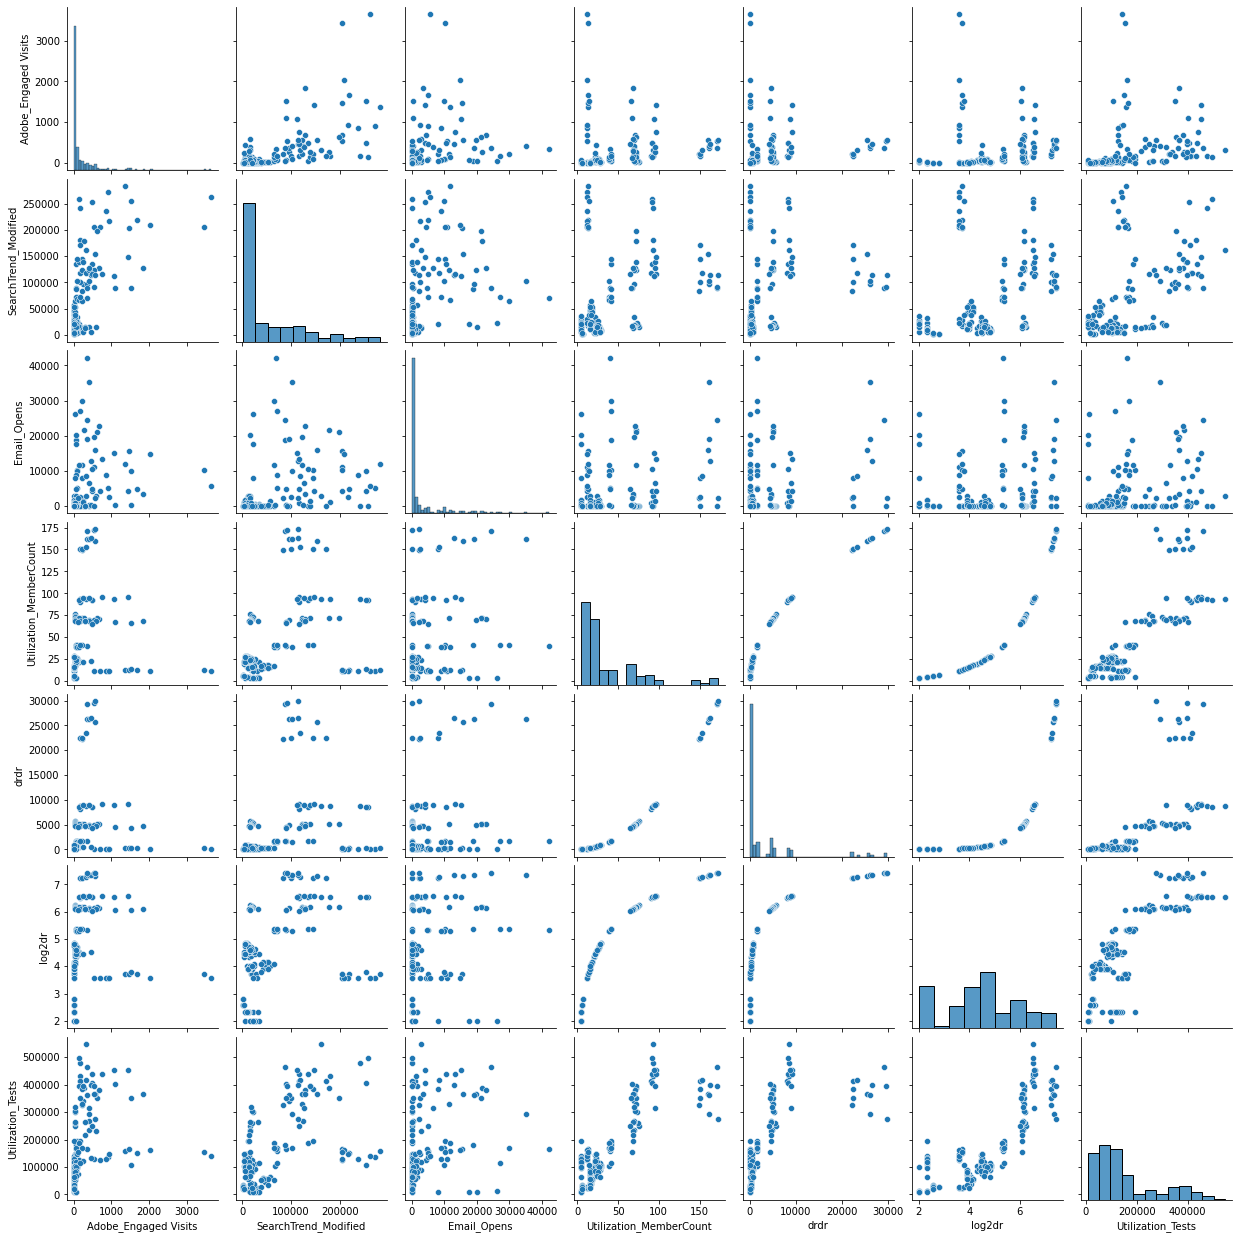

In [9]:
#Look at interactions between the variables. Not very many great relationships except definitely some interactions between # of Drs and Revenue
sns.pairplot(train[["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Utilization_MemberCount','drdr','log2dr','Utilization_Tests']])
plt.show()

In [10]:
!pip install sklearn

     |████████████████████████████████| 22.3 MB 132 kB/s eta 0:00:01    |▎                               | 174 kB 5.1 MB/s eta 0:00:05     |████▏                           | 2.9 MB 5.1 MB/s eta 0:00:04     |██████████████▎                 | 9.9 MB 5.1 MB/s eta 0:00:03��██████████████▉             | 13.1 MB 5.1 MB/s eta 0:00:02
     |████████████████████████████████| 303 kB 44.4 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=7c15b4a4f2adf80b359151b398f6e7baa3c5b99115836f0ec8985856270187b0
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [27]:
#Split the data into train/test datasets and get ready to build a random forest

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

rf = RandomForestRegressor()
X = pd.get_dummies(X)

x_train, x_test, y_train, y_test = train_test_split(X,y)

In [29]:
#Train an OLS regression on the original dataset (NOT INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(X[train_test_cols])
x_train_orig = sm.tools.add_constant(X[train_test_cols[:-2]])
mod = sm.GLS(y, x_train_orig)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(X[train_test_cols[:-2]])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.809
Model:                            GLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     157.3
Date:                Tue, 04 May 2021   Prob (F-statistic):           7.81e-65
Time:                        16:51:38   Log-Likelihood:                -2373.9
No. Observations:                 192   AIC:                             4760.
Df Residuals:                     186   BIC:                             4779.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                    3

In [30]:
#Train an OLS regression on the modified dataset (INCLUDING dr squared or log dr created columns

train_test_cols = ["Adobe_Engaged Visits",'SearchTrend_Modified','Email_Opens','Sales_Calls','Utilization_MemberCount','drdr','log2dr']
x_train_all = sm.tools.add_constant(x_train[train_test_cols])
x_train_orig = sm.tools.add_constant(x_train[train_test_cols[:-2]])
mod = sm.GLS(y_train, x_train_all)
res = mod.fit()
# res = mod.fit_regularized(alpha=0.1)

x_test_gls = sm.tools.add_constant(x_test[train_test_cols])
y_predict_ols = res.predict(x_test_gls)
print(res.summary())

                            GLS Regression Results                            
Dep. Variable:      Utilization_Tests   R-squared:                       0.908
Model:                            GLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     191.3
Date:                Tue, 04 May 2021   Prob (F-statistic):           3.83e-67
Time:                        16:51:46   Log-Likelihood:                -1731.2
No. Observations:                 144   AIC:                             3478.
Df Residuals:                     136   BIC:                             3502.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

In [31]:
#Fit the random forest and predict the values for the test dataset

rf.fit(x_train,y_train)
y_predict_rf = rf.predict(x_test)

In [33]:
#Which variables are most important for the random forest? Number of doctors is the strongest predictor
importances = pd.DataFrame(list(zip(*[x_train.columns,rf.feature_importances_])),columns=['variable','importance'])
importances.sort_values('importance',ascending=False)

,variable,importance
4,Utilization_MemberCount,0.326352
6,log2dr,0.263023
5,drdr,0.231093
3,Sales_Calls,0.080864
0,Adobe_Engaged Visits,0.027761
1,SearchTrend_Modified,0.027589
26,Country_Germany,0.009246
30,Country_Portugal,0.006465
29,Country_Norway,0.005921
2,Email_Opens,0.005234


In [34]:
#Import functions to calculate metrics from sklearn to make it easier to ensure I'm calculating it correctly
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [35]:
mse_rf = mean_squared_error(y_test, y_predict_rf)
mae_rf = mean_absolute_error(y_test, y_predict_rf)
r2_rf = r2_score(y_test, y_predict_rf)
mse_ols = mean_squared_error(y_test, y_predict_ols)
mae_ols = mean_absolute_error(y_test, y_predict_ols)
r2_ols = r2_score(y_test, y_predict_ols)

print(f'OLS\nMSE: {mse_ols:0,.0f}\t\tMAE: {mae_ols:0,.1f}\t\tR-Squared: {r2_ols:0.3f}')
print()
print(f'Random Forest\nMSE: {mse_rf:0,.0f}\t\tMAE: {mae_rf:0,.1f}\t\tR-Squared: {r2_rf:0.3f}')

OLS
MSE: 1,866,703,373		MAE: 32,699.6		R-Squared: 0.863

Random Forest
MSE: 710,872,275		MAE: 17,441.1		R-Squared: 0.948


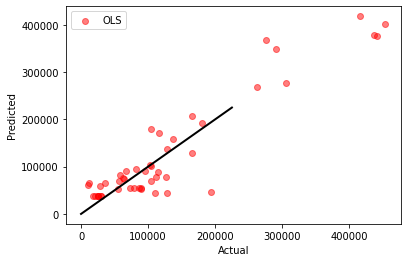

In [36]:
#How closely to the y=x line do the OLS predictions run?
plt.scatter(y_test, y_predict_ols, alpha=0.5, c='r', label='OLS')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()

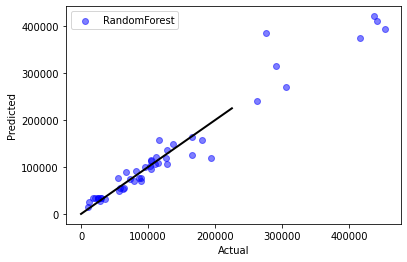

In [37]:
#How closely to the y=x line do the random forest predictions run?
plt.scatter(y_test, y_predict_rf, alpha=0.5, c='b', label='RandomForest')
plt.plot([0, 225000], [0, 225000], color='k', linestyle='-', linewidth=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.legend()
plt.show()